In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from trajectory import run_simulation_trajectory
%load_ext autoreload
%autoreload 2

In [41]:
n = 10000 # Starting plankton population size.
iters = 30 # Time steps.
L_max = 1 # Size of square domain.
colour_map = "hsv"

plankton_dict = run_simulation_trajectory(n, iters, L_max, False)

In [42]:
x = []
y = []
y0 = []
for id in plankton_dict:
    x.append(plankton_dict[id]['x'][-1])
    y.append(plankton_dict[id]['y'][-1])
    y0.append(plankton_dict[id]['y0'])

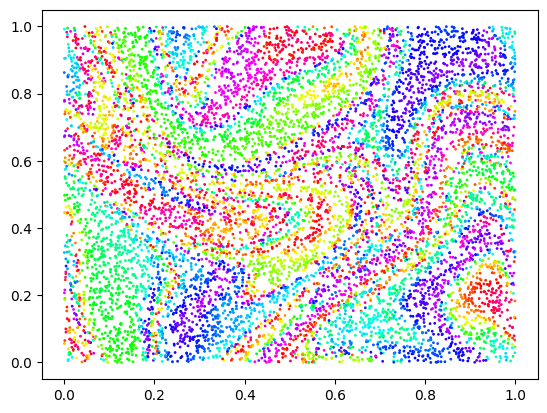

In [43]:
plt.scatter(x, y, c=y0, s=1, cmap=colour_map)
plt.show()

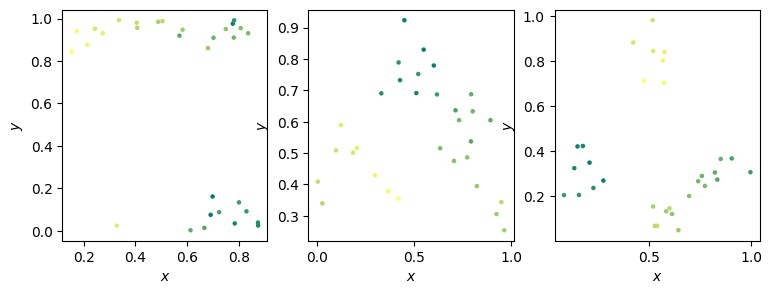

In [47]:
fig, ax = plt.subplots(1,3, figsize=(9,3))

for i,id in enumerate([0,50,100]):
    ax.flatten()[i].set_xlabel('$x$')
    ax.flatten()[i].set_ylabel('$y$')
    ax.flatten()[i].scatter(plankton_dict[id]['x'], plankton_dict[id]['y'], 
                            c=plankton_dict[id]['t'], cmap='summer', s=5)

In [2]:
n = 1000 # Starting plankton population size.
iters = 30 # Time steps.
L_max = 1 # Size of square domain.
colour_map = "hsv"

plankton_dict = run_simulation_trajectory(n, iters, L_max, True)

In [3]:
x = []
y = []
y0 = []
t_final = []
for id in plankton_dict:
    x.append(plankton_dict[id]['x'][-1])
    y.append(plankton_dict[id]['y'][-1])
    t_final.append(plankton_dict[id]['t'][-1])
    y0.append(plankton_dict[id]['y0'])

In [4]:
final_idx = np.where(t_final==np.max(t_final))[0]

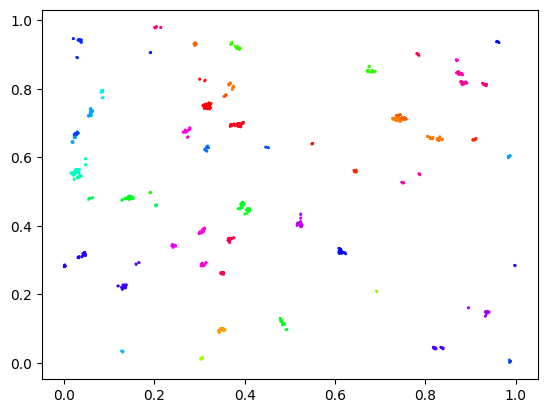

In [5]:
plt.scatter(np.array(x)[final_idx], np.array(y)[final_idx], c=np.array(y0)[final_idx], s=1, cmap=colour_map)
plt.show()

In [6]:
traj_len = []
for id in plankton_dict:
    traj_len.append(len(plankton_dict[id]['x']))
np.where(np.array(traj_len)>=10)

(array([  378,   537,  1647,  2179,  2528,  2622,  2817,  2951,  3359,
         3404,  3434,  4697,  5234,  6051,  6380,  6434,  6891,  8049,
         8373,  9605, 10116, 11385, 11761, 11941, 12289, 12307, 12503,
        13188]),)

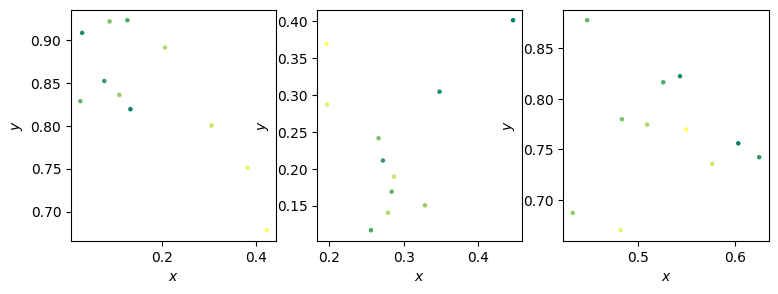

In [7]:
fig, ax = plt.subplots(1,3, figsize=(9,3))

for i,id in enumerate([378,4697,11385]):
    ax.flatten()[i].set_xlabel('$x$')
    ax.flatten()[i].set_ylabel('$y$')
    ax.flatten()[i].scatter(plankton_dict[id]['x'], plankton_dict[id]['y'], 
                            c=plankton_dict[id]['t'], cmap='summer', s=5)

## extract training data

In [ ]:
n = 1000 # Starting plankton population size.
iters = 30 # Time steps.
L_max = 1 # Size of square domain.

plankton_dict = run_simulation_trajectory(n, iters, L_max, True)

In [22]:
min_len = 10
traj_times = []

plankton_ids = list(plankton_dict.keys())
for id in plankton_dict:
    traj_times.append(plankton_dict[id]['t'])

# plankton ids with min trajectory length
len_i = np.where(np.array(traj_len)>=min_len)[0]

In [21]:
list(traj_intersec)[:4]

[26, 27, 28, 29]

In [41]:
def get_coord(id, t):
    x = np.array(plankton_dict[id]['x'])[np.array(plankton_dict[id]['t'])==t]
    y = np.array(plankton_dict[id]['y'])[np.array(plankton_dict[id]['t'])==t]
    return [x,y]

In [46]:
training_data = []

for id1 in len_i:
    for id2 in len_i:
        traj_intersec = set(traj_times[id1]).intersection(set(traj_times[id2]))
        if (len(traj_intersec) >= min_len) & (id1!= id2):
            #print(id1,id2)
            #print(traj_times[id1], traj_times[id2], traj_intersec)
            traj_intersec = list(traj_intersec)[:min_len] #cutting longer intersections
            t1 = traj_intersec[0] 
            t2 = traj_intersec[-1]
            a1 = get_coord(id1, t1)
            a2 = get_coord(id1, t2)
            b1 = get_coord(id2, t1)
            b2 = get_coord(id2, t2)
            training_data.append((np.array((a1,b1,a2,b2)).squeeze()))

In [47]:
training_data

[array([[0.13200803, 0.81944518],
        [0.17199917, 0.79696089],
        [0.38119469, 0.75128551],
        [0.40024836, 0.75480448]]),
 array([[0.17199917, 0.79696089],
        [0.13200803, 0.81944518],
        [0.40024836, 0.75480448],
        [0.38119469, 0.75128551]]),
 array([[0.34464398, 0.84154544],
        [0.17691993, 0.76078182],
        [0.72385084, 0.02468238],
        [0.5664146 , 0.69821938]]),
 array([[0.34464398, 0.84154544],
        [0.76699397, 0.00524544],
        [0.72385084, 0.02468238],
        [0.33196845, 0.92785945]]),
 array([[0.26149441, 0.86111292],
        [0.31392955, 0.10939992],
        [0.81283833, 0.1086782 ],
        [0.53248269, 0.96255194]]),
 array([[0.26149441, 0.86111292],
        [0.29012952, 0.9990308 ],
        [0.81283833, 0.1086782 ],
        [0.70762723, 0.02050171]]),
 array([[0.26149441, 0.86111292],
        [0.81093895, 0.39748688],
        [0.81283833, 0.1086782 ],
        [0.27088467, 0.24627235]]),
 array([[0.33700288, 0.89651834],
